## Gradient Boosting Modeling ##

The models are:
- CatBoost
- LightGBM
- XGBoost
- HistGradientBoosting

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

# import warnings 
# warnings.filterwarnings('ignore')
from pandas import MultiIndex, Int16Dtype

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score

### Prepare data ###

In [3]:
df = pd.read_csv('../data/data_clean/SASS_cleaned_v2.csv', sep=',', header=0)
print(df.shape)

(3640, 57)


In [4]:
cols_ren = {'label_Current_Teacher': 'label_Current',
'vacnc_difficult_STEM_Yes': 'vacnc_STEM',
'number_of_dependents': 'num_dependents',
'region_Northeast': 'region_Northeast',
'region_West': 'region_West',
'marital_status_Married': 'married',
'race_t_White': 'race_T_White',
'race_t_Black': 'race_T_Black',
'race_t_Hispanic': 'race_T_Hispanic',
'gender_t_Female': 'gender_T_Female',
'summer_teaching_Yes': 'summer_teaching',
'nonteaching_job_Yes': 'nonteaching_job',
'nonschool_job_Yes': 'nonschool_job',
'extracur_act_Yes': 'extracur_act',
'merit_pay_Yes': 'merit_pay',
'union_member_Yes': 'union_member',
'BA_major_code_STEM': 'BA_major_STEM',
'MA_major_code_STEM': 'MA_major_STEM',
'main_tch_fields_cert_type_Regular': 'field_cert_Regular',
'MA_deg_Yes': 'deg_T_MA',
'pd_time': 'pd_time',
'pd_finance': 'pd_finance',
'remain_in_teaching': 'remain_teaching',
'STEM_teaching_field': 'field_STEM',
'STEM_hours_taught': 'hrs_taught_STEM',
'public_ft_exp': 'public_ft_exp',
'public_pt_exp': 'public_pt_exp',
'private_ft_exp': 'private_ft_exp',
'class_org': 'class_org',
'main_teaching_lastyr_Same_as_thisyr': 'field_same',
'ft_pt_status_FT': 'full_time',
'teaches_ungraded_Yes': 'teaches_ungraded',
'teaches_7_to_12': 'teaches_7to12',
'new_teacher_Yes': 'new_teacher',
'percent_minority_students': 'minority_students',
'FRPL_eligible_k_12_students': 'FRPL_eligible_k12',
'student_teacher_ratio': 'stu_tch_ratio',
'sch_type': 'sch_type',
'level_Elementary': 'level_Elementary',
'urbanicity': 'urbanicity',
'title_I_receive_students_Yes': 'title_I_receive',
'age_p': 'age_P',
'salary': 'salary_P',
'yrs_princpl_this_sch': 'yrs_P_this_sch',
'yrs_princpl_oth_schls': 'yrs_P_oth_schls',
'yrs_tchng_before_princpl': 'yrs_tch_before_P',
'yrs_tchng_since_princpl': 'yrs_tch_since_P',
'deg_highest_P': 'deg_highest_P',
'race_p_Black': 'race_P_Black',
'race_p_White': 'race_P_White',
'race_p_Hispanic': 'race_P_Hispanic',
'gender_p_Female': 'gender_P_Female',
'incentives_pay': 'incen_pay',
'incentives_recruit_NonSTEM': 'incen_NonSTEM'}
 
df.rename(columns=cols_ren, inplace=True)

In [5]:
df3 = pd.read_csv('../data/data_clean/SASS_cleaned_v3.csv', sep=',', header=0)
temp = [c for c in df.columns if c not in df3.columns]
temp

['class_org', 'teaches_ungraded']

Loading the Feature Selection result report

In [6]:
report = pd.read_csv('../data/data_clean/Task2_Feature_Selection_v2_Report.csv', sep=',', header=0)

In [7]:
report.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(5)

,model,n Selected,type,Counts,Method,Train Accuracy,Test Accuracy,MCC,F1,features,index
60,Grandient Boosting,38,by methods,NaN,Regularization - Lasso,0.799107,0.774725,0.523722,0.769392,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 3]\n [ 4]\n [ 6]\n [ 7]\n [ 9]\n [10...
53,Gradient Boosting,43,by counts,4.0,NaN,0.798764,0.769231,0.511779,0.764017,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 9]\n [10...
54,Gradient Boosting,36,by counts,5.0,NaN,0.801511,0.767857,0.508765,0.762487,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 9]\n [10...
52,Gradient Boosting,51,by counts,3.0,NaN,0.798420,0.766484,0.505873,0.761456,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 0]\n [ 1]\n [ 2]\n [ 3]\n [ 4]\n [ 7]\n [ 8...
62,Grandient Boosting,28,by methods,NaN,Permutation Importance - Random Forest,0.790522,0.766484,0.505873,0.761456,"['remain_teaching', 'public_pt_exp', 'public_f...",[[ 1]\n [ 2]\n [ 3]\n [ 7]\n [ 9]\n [10]\n [11...


**Split data**

In [8]:
label = ['label_Current']

cols_drop = ['CNTLNUM_T', 'SCHCNTL', 'CNTLNUM_P']

y = df[label].values.ravel()
X = df.drop(columns=label + cols_drop).copy()
columns = df.drop(columns=label + cols_drop).columns.tolist()

random_state=123
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,
                                                    random_state=random_state, shuffle=True)
print(X.shape)
print('Data size', X.shape, 'class proportions', np.bincount(y))
print('Train size', X_train.shape, 'class proportions', np.bincount(y_train))
print('Test size', X_test.shape, 'class proportions', np.bincount(y_test))

(3640, 53)
Data size (3640, 53) class proportions [1464 2176]
Train size (2912, 53) class proportions [1171 1741]
Test size (728, 53) class proportions [293 435]


In [9]:
values, counts = np.unique(y_train, return_counts=True)
values_test, counts_test = np.unique(y_test, return_counts=True)
pd.DataFrame({'Label': values.tolist(), 'Train': counts.tolist(), 'Test': counts_test.tolist()})

,Label,Train,Test
0,0,1171,293
1,1,1741,435


In [10]:
categorical_cols = ['vacnc_STEM',
                    'region_Northeast',
                    'region_West',
                    'married',
                    'race_T_White',
                    'race_T_Black',
                    'race_T_Hispanic',
                    'gender_T_Female',
                    'summer_teaching',
                    'nonteaching_job',
                    'nonschool_job',
                    'extracur_act',
                    'merit_pay',
                    'union_member',
                    'BA_major_STEM',
                    'MA_major_STEM',
                    'field_cert_Regular',
                    'deg_T_MA',
                    'pd_time',
                    'pd_finance',
                    'remain_teaching',#
                    'field_STEM',
                    'field_same',
                    'full_time',
                    'teaches_7to12',
                    'new_teacher',
                    'sch_type',#
                    'level_Elementary',
                    'urbanicity',#
                    'title_I_receive',
                    'deg_highest_P',#
                    'race_P_Black',
                    'race_P_White',
                    'race_P_Hispanic',
                    'gender_P_Female',
                    'incen_pay',
                    'incen_NonSTEM',
                    'class_org', 
                    'teaches_ungraded']

categorical_cols_idx = [columns.index(c) for c in categorical_cols]
numerical_cols = [c for c in columns if c not in categorical_cols]
dtype = {c: 'int' for c in categorical_cols}
X_train = X_train.astype(dtype)
X_test = X_test.astype(dtype)

**Normalization**

In [11]:
scaler = StandardScaler()

scaler.fit(X_train[numerical_cols])
X_train[numerical_cols] = scaler.transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

### Experiment with different Feature Sets ###

In [12]:
print('Feature Set 1 (Original Set)')
print('\tn features:', len(columns))

feature_set = report[(report['model'] == 'Lasso') & (report['type'] == 'by methods')].sort_values(by=['n Selected'], ignore_index=True)
# if feature_set['n Selected'].tail(1).values==len(columns): n = feature_set.shape[0]-1
# else: n = feature_set.shape[0]
n = feature_set.shape[0]

for i in range(n):
    print('Feature Set', str(i+2))
    print('\tn features: {:0.0f}'.format(feature_set.loc[i, 'n Selected']))
    if feature_set.loc[i, 'type'] == 'by counts': 
        print('\tSelected by {:0.0f} methods'.format(feature_set.loc[i, 'Counts']))

Feature Set 1 (Original Set)
	n features: 53
Feature Set 2
	n features: 18
Feature Set 3
	n features: 26
Feature Set 4
	n features: 26
Feature Set 5
	n features: 27
Feature Set 6
	n features: 28
Feature Set 7
	n features: 33
Feature Set 8
	n features: 34
Feature Set 9
	n features: 38
Feature Set 10
	n features: 49


In [13]:
n_iter_denom = 4
rounds = 20

In [14]:
def model_report(estimator, param_grid, fit_params, name, categorical=False):
    result = pd.DataFrame()
    cv=5

    n_iter = 1
    for v in param_grid.values(): n_iter*=len(v)
    n_iter /= n_iter_denom
    print('{} n_iter: {:0.0f}'.format(name, n_iter))
    
    for i in range(n+1):
        if i == n: 
            features = columns
            method = 'No Reduction'
        else: 
            features = list(feature_set.loc[i, 'features'].strip("[]''").split("', '"))
            method = feature_set.loc[i, 'Method']
            
        X_train2 = X_train.loc[:, features]
        X_test2 = X_test.loc[:, features]
        
        if categorical:
            categorical_cols2=[features.index(c) for c in categorical_cols if c in features]
            if len(categorical_cols2) > 0:
                if (name == 'LightGBM'): fit_params['categorical_feature']=categorical_cols2
                if (name == 'CatBoost'): fit_params['cat_features']=categorical_cols2
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': categorical_cols2})
            else: 
                if (name == 'LightGBM'): fit_params['categorical_feature']=None
                if (name == 'CatBoost'): fit_params['cat_features']=None
                if (name == 'HistGB'): estimator.set_params(**{'categorical_features': None})    
        
        grid = RandomizedSearchCV(estimator, param_distributions=param_grid, cv=cv, n_jobs=-1, 
                              random_state=random_state, n_iter=n_iter)

        start_cpu = time.process_time()
        start_wall = time.time()
        
        if name == 'CatBoost':
            fit_params['eval_set'] =  [(X_test2, y_test)]
            grid.fit(X_train2, y_train, **fit_params)            
        elif name == 'HistGB': 
            grid.fit(X_train2, y_train)
        else:
            fit_params['eval_set'] =  [(X_test2.values, y_test)]
            grid.fit(X_train2.values, y_train, **fit_params)
            
        cpu_time = time.process_time() - start_cpu
        wall_time = time.time() - start_wall
        y_pred = grid.best_estimator_.predict(X_test2)
        
        temp = {'Model': name,
                'n Selected': len(features),
                'Method': method,
                'best_params': grid.best_params_,
                'Best Accuracy': grid.best_score_, 
                'Train Accuracy': grid.best_estimator_.score(X_train2, y_train),
                'Test Accuracy': accuracy_score(y_test, y_pred),
                'Precision': precision_score(y_test, y_pred),
                'Recall': recall_score(y_test, y_pred),
                'MCC': matthews_corrcoef(y_test, y_pred), 
                'F1': f1_score(y_test, y_pred),
#                 'ROC': roc_auc_score(y_test, grid.best_estimator_.predict_proba(X_test2), multi_class='ovr', average=avg),
                'conf_mat': confusion_matrix(y_test, y_pred), 
                'Prediction': y_pred,
                'predict_proba': grid.best_estimator_.predict_proba(X_test2),
                'Features': features,
                'estimator': grid.best_estimator_,
                'classification_report': classification_report(y_test, y_pred),
                'Train Time CPU': cpu_time,
                'Train Time Wall': wall_time,
                'n_iter': n_iter}
        result = pd.concat([result, pd.DataFrame([temp])], ignore_index=True)
    return result

In [15]:
results = pd.DataFrame()

**CatBoost**

In [16]:
%%time
from catboost import CatBoostClassifier

params = {'iterations': [50, 100, 200],
'depth': [3, 6, 9],
'min_data_in_leaf': [1, 5, 10],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_leaf_reg': [0, 0.01, 0.1, 1, 10],
'random_strength': [0, 5, 10, 15]}

fit_params = {'early_stopping_rounds': rounds}

estimator = CatBoostClassifier(random_seed=random_state, verbose=False, eval_metric="Logloss", one_hot_max_size=5)
result_report=model_report(estimator, params, fit_params, 'CatBoost', True)
results=pd.concat([results, result_report], ignore_index=True)

CatBoost n_iter: 540
CPU times: total: 1min 59s
Wall time: 29min 1s


**XGBoost**

In [17]:
%%time
import xgboost

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, 0],
'min_child_weight': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'alpha': [0,  0.1, 10],
'lambda': [0,  0.1, 10],
'gamma': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = xgboost.XGBClassifier(seed=random_state, objective="binary:logistic", eval_metric="logloss", use_label_encoder=False)
result_report=model_report(estimator, params, fit_params, 'XGBoost', False)
results=pd.concat([results, result_report], ignore_index=True)

XGBoost n_iter: 972


C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[0]	validation_0-logloss:0.66455
[1]	validation_0-logloss:0.64576
[2]	validation_0-logloss:0.63238
[3]	validation_0-logloss:0.62351
[4]	validation_0-logloss:0.61396
[5]	validation_0-logloss:0.60637
[6]	validation_0-logloss:0.59743
[7]	validation_0-logloss:0.59135
[8]	validation_0-logloss:0.58460
[9]	validation_0-logloss:0.58092
[10]	validation_0-logloss:0.57614
[11]	validation_0-logloss:0.57251
[12]	validation_0-logloss:0.56662
[13]	validation_0-logloss:0.56273
[14]	validation_0-logloss:0.55991
[15]	validation_0-logloss:0.55758
[16]	validation_0-logloss:0.55335
[17]	validation_0-logloss:0.55154
[18]	validation_0-logloss:0.54960
[19]	validation_0-logloss:0.54839
[20]	validation_0-logloss:0.54693
[21]	validation_0-logloss:0.54387
[22]	validation_0-logloss:0.54207
[23]	validation_0-logloss:0.54177
[24]	validation_0-logloss:0.54018
[25]	validation_0-logloss:0.53922
[26]	validation_0-logloss:0.53795
[27]	validation_0-logloss:0.53681
[28]	validation_0-logloss:0.53563
[29]	validation_0-loglos

[39]	validation_0-logloss:0.49995
[40]	validation_0-logloss:0.49995
[41]	validation_0-logloss:0.49995
[42]	validation_0-logloss:0.49995
[43]	validation_0-logloss:0.49995
[44]	validation_0-logloss:0.49995
[45]	validation_0-logloss:0.49995
[46]	validation_0-logloss:0.49995
[47]	validation_0-logloss:0.49995
[48]	validation_0-logloss:0.49995
[0]	validation_0-logloss:0.65380
[1]	validation_0-logloss:0.63274
[2]	validation_0-logloss:0.62080
[3]	validation_0-logloss:0.60831
[4]	validation_0-logloss:0.59855
[5]	validation_0-logloss:0.59026
[6]	validation_0-logloss:0.58050
[7]	validation_0-logloss:0.57463
[8]	validation_0-logloss:0.56948
[9]	validation_0-logloss:0.56636
[10]	validation_0-logloss:0.56330
[11]	validation_0-logloss:0.55946
[12]	validation_0-logloss:0.55492
[13]	validation_0-logloss:0.55232
[14]	validation_0-logloss:0.55070
[15]	validation_0-logloss:0.54918
[16]	validation_0-logloss:0.54609
[17]	validation_0-logloss:0.54450
[18]	validation_0-logloss:0.54359
[19]	validation_0-loglos

[29]	validation_0-logloss:0.50330
[30]	validation_0-logloss:0.50314
[31]	validation_0-logloss:0.50258
[32]	validation_0-logloss:0.50255
[33]	validation_0-logloss:0.50231
[34]	validation_0-logloss:0.50211
[35]	validation_0-logloss:0.50242
[36]	validation_0-logloss:0.50224
[37]	validation_0-logloss:0.50173
[38]	validation_0-logloss:0.50240
[39]	validation_0-logloss:0.50240
[40]	validation_0-logloss:0.50240
[41]	validation_0-logloss:0.50240
[42]	validation_0-logloss:0.50240
[43]	validation_0-logloss:0.50240
[44]	validation_0-logloss:0.50240
[45]	validation_0-logloss:0.50240
[46]	validation_0-logloss:0.50240
[47]	validation_0-logloss:0.50240
[48]	validation_0-logloss:0.50240
[49]	validation_0-logloss:0.50240
[50]	validation_0-logloss:0.50240
[51]	validation_0-logloss:0.50240
[52]	validation_0-logloss:0.50240
[53]	validation_0-logloss:0.50240
[54]	validation_0-logloss:0.50240
[55]	validation_0-logloss:0.50240
[56]	validation_0-logloss:0.50240
[57]	validation_0-logloss:0.50240
[0]	validation

[10]	validation_0-logloss:0.51631
[11]	validation_0-logloss:0.51438
[12]	validation_0-logloss:0.51212
[13]	validation_0-logloss:0.50995
[14]	validation_0-logloss:0.50774
[15]	validation_0-logloss:0.50668
[16]	validation_0-logloss:0.50623
[17]	validation_0-logloss:0.50390
[18]	validation_0-logloss:0.50242
[19]	validation_0-logloss:0.50182
[20]	validation_0-logloss:0.49967
[21]	validation_0-logloss:0.49998
[22]	validation_0-logloss:0.49999
[23]	validation_0-logloss:0.49965
[24]	validation_0-logloss:0.49901
[25]	validation_0-logloss:0.49818
[26]	validation_0-logloss:0.49806
[27]	validation_0-logloss:0.49793
[28]	validation_0-logloss:0.49799
[29]	validation_0-logloss:0.49770
[30]	validation_0-logloss:0.49677
[31]	validation_0-logloss:0.49622
[32]	validation_0-logloss:0.49602
[33]	validation_0-logloss:0.49602
[34]	validation_0-logloss:0.49602
[35]	validation_0-logloss:0.49602
[36]	validation_0-logloss:0.49602
[37]	validation_0-logloss:0.49602
[38]	validation_0-logloss:0.49602
[39]	validatio

[196]	validation_0-logloss:0.50508
[197]	validation_0-logloss:0.50515
[198]	validation_0-logloss:0.50538
[199]	validation_0-logloss:0.50550
[0]	validation_0-logloss:0.65246
[1]	validation_0-logloss:0.62973
[2]	validation_0-logloss:0.61696
[3]	validation_0-logloss:0.60369
[4]	validation_0-logloss:0.58927
[5]	validation_0-logloss:0.58019
[6]	validation_0-logloss:0.57178
[7]	validation_0-logloss:0.56576
[8]	validation_0-logloss:0.56066
[9]	validation_0-logloss:0.55570
[10]	validation_0-logloss:0.54909
[11]	validation_0-logloss:0.54608
[12]	validation_0-logloss:0.54409
[13]	validation_0-logloss:0.54156
[14]	validation_0-logloss:0.54009
[15]	validation_0-logloss:0.53970
[16]	validation_0-logloss:0.53565
[17]	validation_0-logloss:0.53427
[18]	validation_0-logloss:0.53244
[19]	validation_0-logloss:0.53092
[20]	validation_0-logloss:0.53024
[21]	validation_0-logloss:0.52958
[22]	validation_0-logloss:0.52782
[23]	validation_0-logloss:0.52755
[24]	validation_0-logloss:0.52750
[25]	validation_0-lo

[36]	validation_0-logloss:0.52105
[37]	validation_0-logloss:0.52033
[38]	validation_0-logloss:0.51957
[39]	validation_0-logloss:0.51883
[40]	validation_0-logloss:0.51897
[41]	validation_0-logloss:0.51907
[42]	validation_0-logloss:0.51890
[43]	validation_0-logloss:0.51825
[44]	validation_0-logloss:0.51730
[45]	validation_0-logloss:0.51657
[46]	validation_0-logloss:0.51624
[47]	validation_0-logloss:0.51625
[48]	validation_0-logloss:0.51648
[49]	validation_0-logloss:0.51488
[50]	validation_0-logloss:0.51479
[51]	validation_0-logloss:0.51462
[52]	validation_0-logloss:0.51411
[53]	validation_0-logloss:0.51360
[54]	validation_0-logloss:0.51306
[55]	validation_0-logloss:0.51364
[56]	validation_0-logloss:0.51297
[57]	validation_0-logloss:0.51253
[58]	validation_0-logloss:0.51207
[59]	validation_0-logloss:0.51199
[60]	validation_0-logloss:0.51216
[61]	validation_0-logloss:0.51225
[62]	validation_0-logloss:0.51214
[63]	validation_0-logloss:0.51241
[64]	validation_0-logloss:0.51248
[65]	validatio

**LightGBM**

In [18]:
%%time
import lightgbm as lgb

params = {'n_estimators': [50, 100, 200],
'max_depth': [1, 6, -1],
'min_sum_hessian_in_leaf': [0, 0.001, 0.1, 1],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'reg_alpha': [0,  0.1, 10],
'reg_lambda': [0,  0.1, 10],
'min_split_gain': [0,  0.1, 10]}

fit_params = {'early_stopping_rounds': rounds}

estimator = lgb.LGBMClassifier(random_state=random_state, objective="binary", metric="binary_logloss", verbosity=-1, silent=True, force_col_wise=True)
result_report=model_report(estimator, params, fit_params, 'LightGBM', True)
results=pd.concat([results, result_report], ignore_index=True)

LightGBM n_iter: 972


C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 10, 11, 13, 14, 15, 16, 17]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's binary_logloss: 0.652082
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.637941
[3]	valid_0's binary_logloss: 0.62785
[4]	valid_0's binary_logloss: 0.62018
[5]	valid_0's binary_logloss: 0.611326
[6]	valid_0's binary_logloss: 0.601512
[7]	valid_0's binary_logloss: 0.594685
[8]	valid_0's binary_logloss: 0.588952
[9]	valid_0's binary_logloss: 0.583278
[10]	valid_0's binary_logloss: 0.579458
[11]	valid_0's binary_logloss: 0.574881
[12]	valid_0's binary_logloss: 0.570204
[13]	valid_0's binary_logloss: 0.566763
[14]	valid_0's binary_logloss: 0.561136
[15]	valid_0's binary_logloss: 0.557434
[16]	valid_0's binary_logloss: 0.554632
[17]	valid_0's binary_logloss: 0.552424
[18]	valid_0's binary_logloss: 0.549696
[19]	valid_0's binary_logloss: 0.545764
[20]	valid_0's binary_logloss: 0.544171
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's binary_logloss: 0.64265
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.626248
[3]	valid_0's binary_logloss: 0.61326
[4]	valid_0's binary_logloss: 0.603214
[5]	valid_0's binary_logloss: 0.589698
[6]	valid_0's binary_logloss: 0.580418
[7]	valid_0's binary_logloss: 0.572684
[8]	valid_0's binary_logloss: 0.566836
[9]	valid_0's binary_logloss: 0.560683
[10]	valid_0's binary_logloss: 0.555592
[11]	valid_0's binary_logloss: 0.552929
[12]	valid_0's binary_logloss: 0.548962
[13]	valid_0's binary_logloss: 0.543136
[14]	valid_0's binary_logloss: 0.540441
[15]	valid_0's binary_logloss: 0.537719
[16]	valid_0's binary_logloss: 0.53608
[17]	valid_0's binary_logloss: 0.535678
[18]	valid_0's binary_logloss: 0.533777
[19]	valid_0's binary_logloss: 0.531651
[20]	valid_0's binary_logloss: 0.528073
[21]	valid_

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 7, 8, 9, 11, 12, 13, 14, 17, 18, 19, 21, 22, 23, 24, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.642193
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.626172
[3]	valid_0's binary_logloss: 0.613637
[4]	valid_0's binary_logloss: 0.603895
[5]	valid_0's binary_logloss: 0.595765
[6]	valid_0's binary_logloss: 0.586143
[7]	valid_0's binary_logloss: 0.580412
[8]	valid_0's binary_logloss: 0.571886
[9]	valid_0's binary_logloss: 0.565769
[10]	valid_0's binary_logloss: 0.560325
[11]	valid_0's binary_logloss: 0.557692
[12]	valid_0's binary_logloss: 0.554968
[13]	valid_0's binary_logloss: 0.551344
[14]	valid_0's binary_logloss: 0.548457
[15]	valid_0's binary_logloss: 0.544472
[16]	valid_0's binary_logloss: 0.542827
[17]	valid_0's binary_logloss: 0.541534
[18]	valid_0's binary_logloss: 0.538839
[19]	valid_0's binary_logloss: 0.536946
[20]	valid_0's binary_logloss: 0.535443
[21]	valid_0

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 20, 21, 22, 23, 25]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.1
[1]	valid_0's binary_logloss: 0.654466
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.637615
[3]	valid_0's binary_logloss: 0.623766
[4]	valid_0's binary_logloss: 0.610836
[5]	valid_0's binary_logloss: 0.601308
[6]	valid_0's binary_logloss: 0.591763
[7]	valid_0's binary_logloss: 0.583564
[8]	valid_0's binary_logloss: 0.575986
[9]	valid_0's binary_logloss: 0.569324
[10]	valid_0's binary_logloss: 0.563738
[11]	valid_0's binary_logloss: 0.558485
[12]	valid_0's binary_logloss: 0.553401
[13]	valid_0's binary_logloss: 0.549352
[14]	valid_0's binary_logloss: 0.544876
[15]	valid_0's binary_logloss: 0.541289
[16]	valid_0's binary_logloss: 0.537766
[17]	valid_0's binary_logloss: 0.535536
[18]	valid_0's binary_logloss: 0.533082
[19]	valid_0's binary_logloss: 0.530963
[20]	valid_0's binary_logloss: 0.528911
[21]	val

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0
[1]	valid_0's binary_logloss: 0.652082
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.637941
[3]	valid_0's binary_logloss: 0.62785
[4]	valid_0's binary_logloss: 0.62018
[5]	valid_0's binary_logloss: 0.611326
[6]	valid_0's binary_logloss: 0.601512
[7]	valid_0's binary_logloss: 0.594685
[8]	valid_0's binary_logloss: 0.588952
[9]	valid_0's binary_logloss: 0.583278
[10]	valid_0's binary_logloss: 0.579458
[11]	valid_0's binary_logloss: 0.574881
[12]	valid_0's binary_logloss: 0.570204
[13]	valid_0's binary_logloss: 0.566763
[14]	valid_0's binary_logloss: 0.561136
[15]	valid_0's binary_logloss: 0.557434
[16]	valid_0's binary_logloss: 0.554632
[17]	valid_0's binary_logloss: 0.552424
[18]	valid_0's binary_logloss: 0.549696
[19]	valid_0's binary_logloss: 0.545764
[20]	valid_0's binary_logloss: 0.544171
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 5, 7, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.644133
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.628153
[3]	valid_0's binary_logloss: 0.615786
[4]	valid_0's binary_logloss: 0.606176
[5]	valid_0's binary_logloss: 0.593391
[6]	valid_0's binary_logloss: 0.585742
[7]	valid_0's binary_logloss: 0.577481
[8]	valid_0's binary_logloss: 0.571711
[9]	valid_0's binary_logloss: 0.56797
[10]	valid_0's binary_logloss: 0.563439
[11]	valid_0's binary_logloss: 0.558312
[12]	valid_0's binary_logloss: 0.552682
[13]	valid_0's binary_logloss: 0.549778
[14]	valid_0's binary_logloss: 0.546308
[15]	valid_0's binary_logloss: 0.543584
[16]	valid_0's binary_logloss: 0.541968
[17]	valid_0's binary_logloss: 0.53982
[18]	valid_0's binary_logloss: 0.538472
[19]	valid_0's binary_logloss: 0.535085
[20]	valid_0's binary_logloss: 0.534692
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 19, 21, 23, 24, 25, 26, 28, 29, 31, 32, 33]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=0.001, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=0.001
[1]	valid_0's binary_logloss: 0.642805
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.625093
[3]	valid_0's binary_logloss: 0.614045
[4]	valid_0's binary_logloss: 0.601479
[5]	valid_0's binary_logloss: 0.587509
[6]	valid_0's binary_logloss: 0.577182
[7]	valid_0's binary_logloss: 0.569464
[8]	valid_0's binary_logloss: 0.563595
[9]	valid_0's binary_logloss: 0.55751
[10]	valid_0's binary_logloss: 0.552475
[11]	valid_0's binary_logloss: 0.548092
[12]	valid_0's binary_logloss: 0.541926
[13]	valid_0's binary_logloss: 0.53917
[14]	valid_0's binary_logloss: 0.537205
[15]	valid_0's binary_logloss: 0.534752
[16]	valid_0's binary_logloss: 0.53322
[17]	valid_0's binary_logloss: 0.53279
[18]	valid_0's binary_logloss: 0.529006
[19]	valid_0's binary_logloss: 0.527759
[20]	valid_0's binary_logloss: 0.525993
[21]	val

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 11, 12, 13, 14, 15, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.653675
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.635946
[3]	valid_0's binary_logloss: 0.622159
[4]	valid_0's binary_logloss: 0.607791
[5]	valid_0's binary_logloss: 0.596818
[6]	valid_0's binary_logloss: 0.58601
[7]	valid_0's binary_logloss: 0.577208
[8]	valid_0's binary_logloss: 0.568782
[9]	valid_0's binary_logloss: 0.562106
[10]	valid_0's binary_logloss: 0.555259
[11]	valid_0's binary_logloss: 0.54976
[12]	valid_0's binary_logloss: 0.545894
[13]	valid_0's binary_logloss: 0.540867
[14]	valid_0's binary_logloss: 0.53693
[15]	valid_0's binary_logloss: 0.532931
[16]	valid_0's binary_logloss: 0.529319
[17]	valid_0's binary_logloss: 0.527143
[18]	valid_0's binary_logloss: 0.52521
[19]	valid_0's binary_logloss: 0.522863
[20]	valid_0's binary_logloss: 0.52094
[21]	valid_0's bi

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 3, 4, 6, 8, 12, 13, 14, 15, 16, 20, 21, 22, 23, 25, 26, 28, 29, 30, 31, 32, 33, 34, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 47, 48]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[LightGBM] [Warning] min_sum_hessian_in_leaf is set=1, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=1
[1]	valid_0's binary_logloss: 0.642797
Training until validation scores don't improve for 20 rounds
[2]	valid_0's binary_logloss: 0.62509
[3]	valid_0's binary_logloss: 0.614046
[4]	valid_0's binary_logloss: 0.601484
[5]	valid_0's binary_logloss: 0.587519
[6]	valid_0's binary_logloss: 0.577191
[7]	valid_0's binary_logloss: 0.569476
[8]	valid_0's binary_logloss: 0.563608
[9]	valid_0's binary_logloss: 0.557527
[10]	valid_0's binary_logloss: 0.552494
[11]	valid_0's binary_logloss: 0.548113
[12]	valid_0's binary_logloss: 0.54195
[13]	valid_0's binary_logloss: 0.539194
[14]	valid_0's binary_logloss: 0.537229
[15]	valid_0's binary_logloss: 0.534778
[16]	valid_0's binary_logloss: 0.533246
[17]	valid_0's binary_logloss: 0.532817
[18]	valid_0's binary_logloss: 0.529035
[19]	valid_0's binary_logloss: 0.527788
[20]	valid_0's binary_logloss: 0.526025
[21]	valid_0's

C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1702: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 46, 47, 48, 49, 50, 51, 52]
  _log_warning('categorical_feature in Dataset is overridden.\n'
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\PC3\anaconda3\envs\ML310\lib\site-packages\lightgbm\basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


**HistGradientBoosting**

In [19]:
%%time
from sklearn.ensemble import HistGradientBoostingClassifier

params = {'max_iter': [50, 100, 200],
'max_depth': [1, 6, None],
'max_leaf_nodes': [10, 31, 50, 64],
'min_samples_leaf': [10, 20, 30],
'learning_rate': [0.01, 0.1, 0.2, 0.3],
'l2_regularization': [0, 0.01, 0.1, 1, 10]}

fit_params = {}

estimator=HistGradientBoostingClassifier(random_state=random_state, n_iter_no_change=rounds, early_stopping=True)
result_report=model_report(estimator, params, fit_params, 'HistGB', True)
results=pd.concat([results, result_report], ignore_index=True)

HistGB n_iter: 540
CPU times: total: 1min 33s
Wall time: 36min 25s


## Result ##

In [20]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)[['Model', 'Method', 'n Selected', 'Test Accuracy', 'Precision', 'Recall', 'MCC', 'F1', 'best_params']]

,Model,Method,n Selected,Test Accuracy,Precision,Recall,MCC,F1,best_params
26,LightGBM,Variance Threshold,34,0.780220,0.777778,0.885057,0.535739,0.827957,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimat..."
16,XGBoost,Variance Threshold,34,0.780220,0.781186,0.878161,0.535698,0.826840,"{'n_estimators': 200, 'min_child_weight': 0.00..."
29,LightGBM,No Reduction,53,0.778846,0.778455,0.880460,0.532703,0.826321,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
38,HistGB,RFE - Random Forest,49,0.778846,0.778455,0.880460,0.532703,0.826321,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,..."
9,CatBoost,No Reduction,53,0.777473,0.769231,0.896552,0.530322,0.828025,"{'random_strength': 0, 'min_data_in_leaf': 5, ..."
34,HistGB,Permutation Importance - Random Forest,28,0.777473,0.779141,0.875862,0.529733,0.824675,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,..."
28,LightGBM,RFE - Random Forest,49,0.777473,0.776876,0.880460,0.529713,0.825431,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat..."
36,HistGB,Variance Threshold,34,0.777473,0.776876,0.880460,0.529713,0.825431,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,..."
7,CatBoost,Regularization - Lasso,38,0.776099,0.766667,0.898851,0.527538,0.827513,"{'random_strength': 5, 'min_data_in_leaf': 5, ..."
6,CatBoost,Variance Threshold,34,0.776099,0.769841,0.891954,0.527065,0.826411,"{'random_strength': 10, 'min_data_in_leaf': 5,..."


In [21]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)['Model'].value_counts().to_frame()

,Model
LightGBM,3
HistGB,3
CatBoost,3
XGBoost,1


In [22]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)['n Selected'].value_counts().sort_index().to_frame()

,n Selected
28,1
34,4
38,1
49,2
53,2


**Accuracy, MCC and F1 Score**

In [23]:
results2 = pd.DataFrame()
for col in ['Train Accuracy', 'Test Accuracy', 'MCC', 'F1']:
    temp = results[['Model', 'n Selected'] + [col]].copy()
    temp['Score'] = col
    temp.rename(columns={col: 'Score value'}, inplace=True)
    results2 = pd.concat([results2, temp], ignore_index=True)
results2=results2.astype({'n Selected': 'int32'})

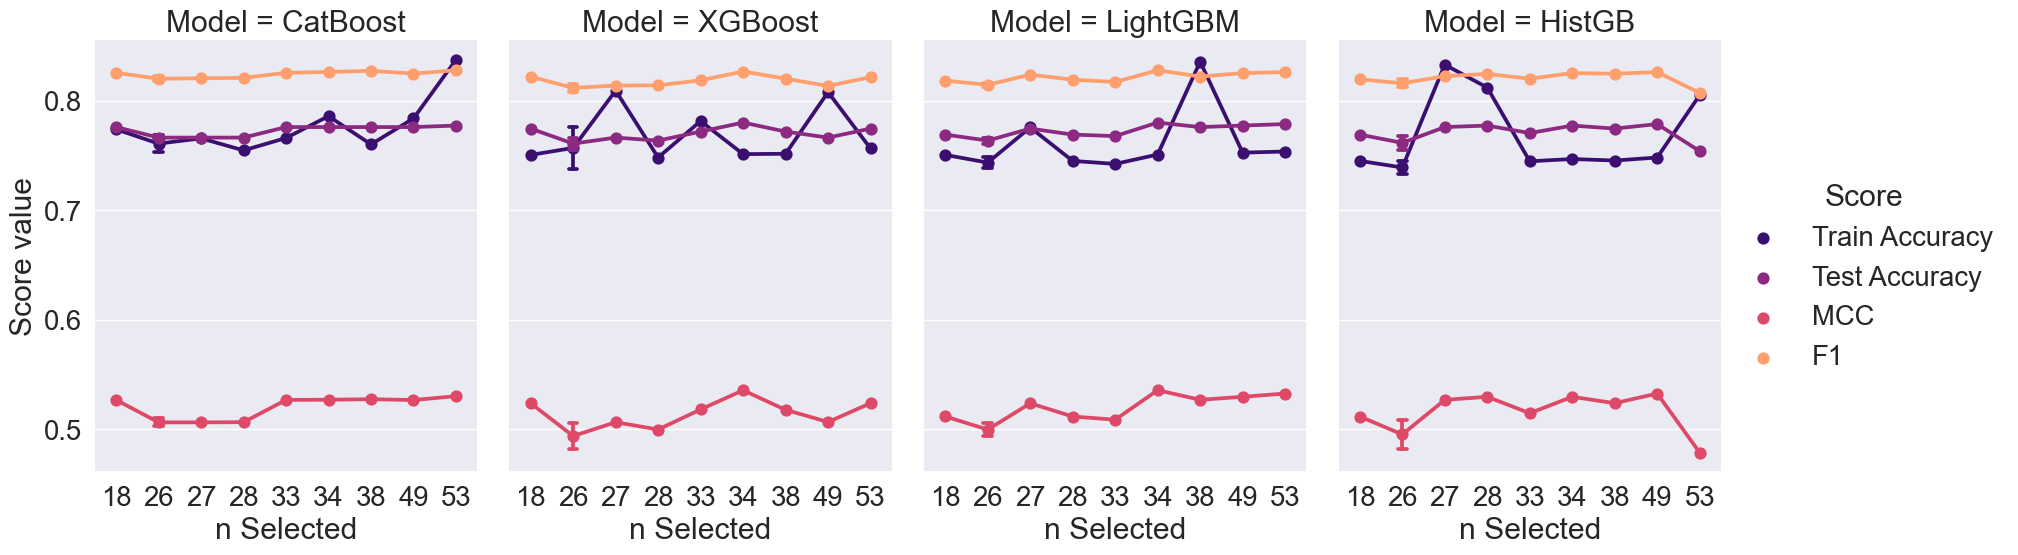

In [24]:
sns.set(rc={'figure.figsize':(20,20)})
sns.set_theme(style='whitegrid')
sns.set(font_scale=1.8)

g = sns.catplot(x="n Selected", y="Score value", hue="Score", col="Model",
                capsize=.2, palette="magma", height=6, aspect=.75,
                kind="point", data=results2)
g.despine(left=True)
plt.show()

In [25]:
best_train=results.groupby(['Model'], as_index=False).agg({'Train Accuracy': 'max'})
best_test=results.groupby(['Model'], as_index=False).agg({'Test Accuracy': 'max'})

max_test=[]
for m, a in best_test.values:
    max_test.append(results.loc[(results['Model']==m) & (results['Test Accuracy']==a) , results.columns].index.values[0])

max_train=[]
for m, a in best_train.values:
    max_train.append(results.loc[(results['Model']==m) & (results['Train Accuracy']==a) , results.columns].index.values[0])

**Confusion Matrix**

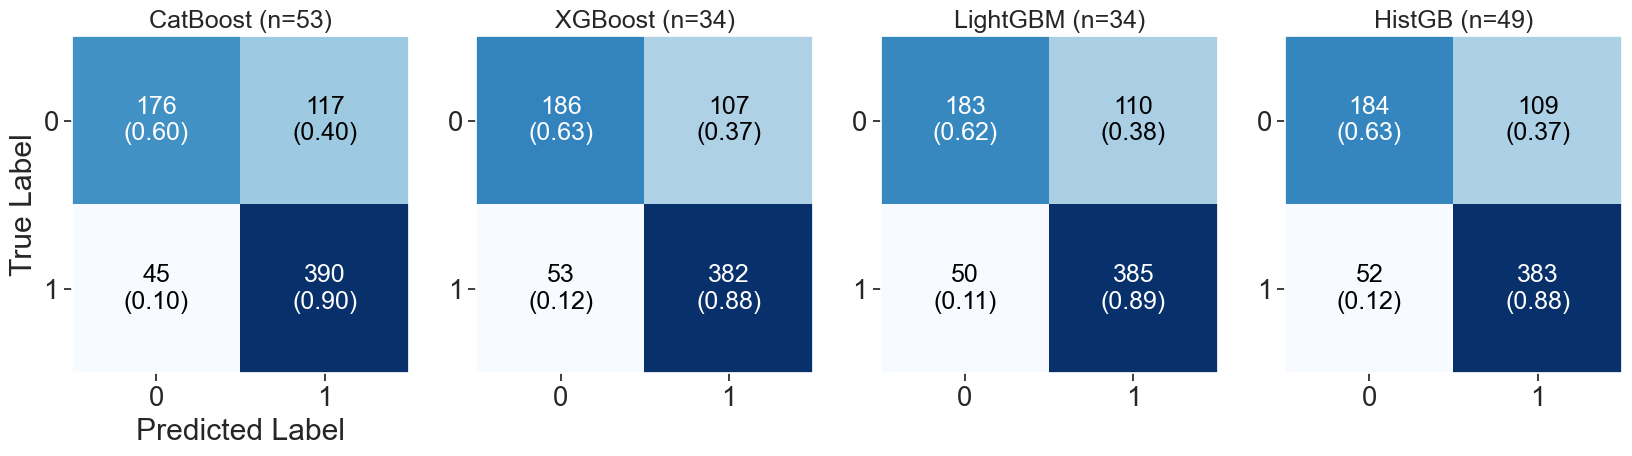

In [26]:
from mlxtend.plotting import plot_confusion_matrix
    
fig, axes=plt.subplots(1,4, figsize=(20,10))
sns.set(font_scale=1.5)

for idx, i in zip(sorted(max_test), range(len(max_test))):
    plot_confusion_matrix(axis=axes[i], conf_mat=results.loc[idx, 'conf_mat'], show_absolute=True, 
                                  show_normed=True)
    title='{} (n={:0.0f})'.format(results.loc[idx, 'Model'], results.loc[idx, 'n Selected'])
    axes[i].set(title=title)
    if (i > 0): axes[i].set(xlabel='', ylabel='')
    else : axes[i].set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

**Precision-Recall Curve**

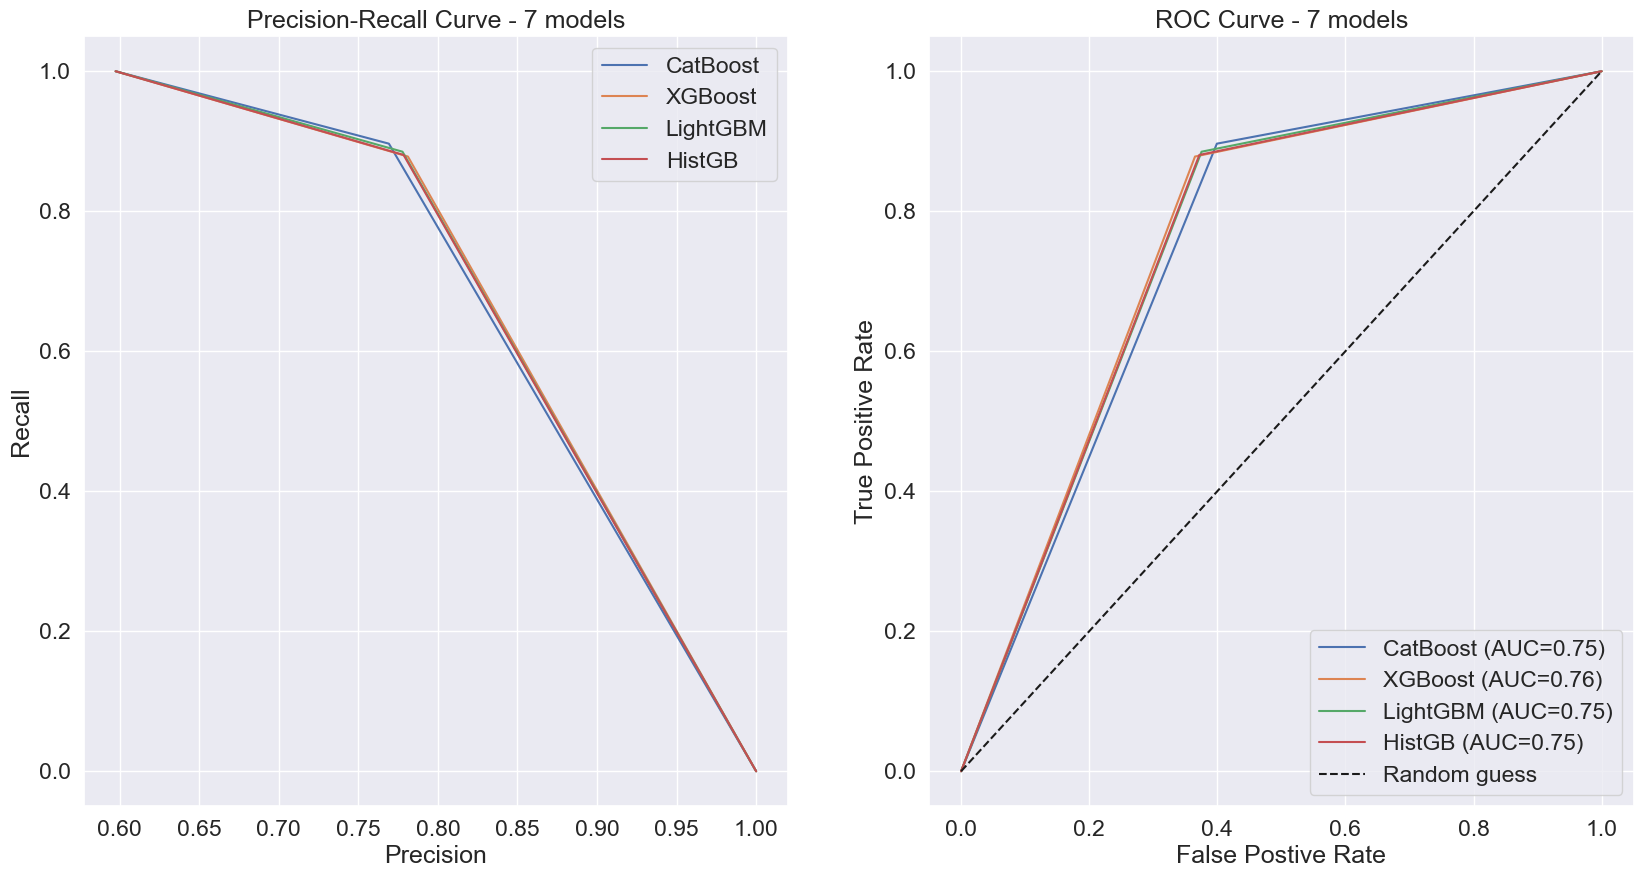

In [27]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc

fig, axes=plt.subplots(1,2, figsize=(20,10))

for idx in sorted(max_test):
    prec, rec, thr = precision_recall_curve(y_test, results.loc[idx, 'Prediction'])
    axes[0].plot(prec, rec, label=results.loc[idx, 'Model'])
axes[0].set(title='Precision-Recall Curve - 7 models', xlabel='Precision', ylabel='Recall')
axes[0].legend(loc="best")

for idx in sorted(max_test):
    fpr, tpr, thr = roc_curve(y_test, results.loc[idx, 'Prediction'])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=results.loc[idx, 'Model']+' (AUC={:0.2f})'.format(roc_auc))
axes[1].plot([0, 1], [0, 1], 'k--', label='Random guess')
axes[1].set(title='ROC Curve - 7 models', xlabel='False Postive Rate', ylabel='True Positive Rate')
axes[1].legend(loc="best")

plt.show()

In [28]:
results.loc[max_test]

,Model,n Selected,Method,best_params,Best Accuracy,Train Accuracy,Test Accuracy,Precision,Recall,MCC,F1,conf_mat,Prediction,predict_proba,Features,estimator,classification_report,Train Time CPU,Train Time Wall,n_iter
9,CatBoost,53,No Reduction,"{'random_strength': 0, 'min_data_in_leaf': 5, ...",0.744850,0.837569,0.777473,0.769231,0.896552,0.530322,0.828025,"[[176, 117], [45, 390]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.04483152307801974, 0.9551684769219803], [0...","[vacnc_STEM, num_dependents, region_Northeast,...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,15.046875,274.457041,540.0
38,HistGB,49,RFE - Random Forest,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,...",0.741064,0.748283,0.778846,0.778455,0.880460,0.532703,0.826321,"[[184, 109], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08412308085315923, 0.9158769191468408], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.000000,270.159638,540.0
26,LightGBM,34,Variance Threshold,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimat...",0.745185,0.751030,0.780220,0.777778,0.885057,0.535739,0.827957,"[[183, 110], [50, 385]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.06605037279717041, 0.9339496272028296], [0...","[remain_teaching, public_pt_exp, public_ft_exp...","LGBMClassifier(force_col_wise=True, learning_r...",precision recall f1-score ...,10.687500,94.201286,972.0
16,XGBoost,34,Variance Threshold,"{'n_estimators': 200, 'min_child_weight': 0.00...",0.739695,0.751374,0.780220,0.781186,0.878161,0.535698,0.826840,"[[186, 107], [53, 382]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.065971196, 0.9340288], [0.7887435, 0.21125...","[remain_teaching, public_pt_exp, public_ft_exp...","XGBClassifier(alpha=0.1, base_score=0.5, boost...",precision recall f1-score ...,20.234375,135.142166,972.0


In [29]:
results.sort_values(by=['Test Accuracy', 'MCC'], ascending=False).head(10)

,Model,n Selected,Method,best_params,Best Accuracy,Train Accuracy,Test Accuracy,Precision,Recall,MCC,F1,conf_mat,Prediction,predict_proba,Features,estimator,classification_report,Train Time CPU,Train Time Wall,n_iter
26,LightGBM,34,Variance Threshold,"{'reg_lambda': 0.1, 'reg_alpha': 0, 'n_estimat...",0.745185,0.751030,0.780220,0.777778,0.885057,0.535739,0.827957,"[[183, 110], [50, 385]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.06605037279717041, 0.9339496272028296], [0...","[remain_teaching, public_pt_exp, public_ft_exp...","LGBMClassifier(force_col_wise=True, learning_r...",precision recall f1-score ...,10.687500,94.201286,972.0
16,XGBoost,34,Variance Threshold,"{'n_estimators': 200, 'min_child_weight': 0.00...",0.739695,0.751374,0.780220,0.781186,0.878161,0.535698,0.826840,"[[186, 107], [53, 382]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.065971196, 0.9340288], [0.7887435, 0.21125...","[remain_teaching, public_pt_exp, public_ft_exp...","XGBClassifier(alpha=0.1, base_score=0.5, boost...",precision recall f1-score ...,20.234375,135.142166,972.0
29,LightGBM,53,No Reduction,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat...",0.744840,0.753777,0.778846,0.778455,0.880460,0.532703,0.826321,"[[184, 109], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07354608559358655, 0.9264539144064134], [0...","[vacnc_STEM, num_dependents, region_Northeast,...","LGBMClassifier(force_col_wise=True, learning_r...",precision recall f1-score ...,8.531250,100.313176,972.0
38,HistGB,49,RFE - Random Forest,"{'min_samples_leaf': 30, 'max_leaf_nodes': 50,...",0.741064,0.748283,0.778846,0.778455,0.880460,0.532703,0.826321,"[[184, 109], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.08412308085315923, 0.9158769191468408], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.000000,270.159638,540.0
9,CatBoost,53,No Reduction,"{'random_strength': 0, 'min_data_in_leaf': 5, ...",0.744850,0.837569,0.777473,0.769231,0.896552,0.530322,0.828025,"[[176, 117], [45, 390]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.04483152307801974, 0.9551684769219803], [0...","[vacnc_STEM, num_dependents, region_Northeast,...",<catboost.core.CatBoostClassifier object at 0x...,precision recall f1-score ...,15.046875,274.457041,540.0
34,HistGB,28,Permutation Importance - Random Forest,"{'min_samples_leaf': 10, 'max_leaf_nodes': 10,...",0.740725,0.812157,0.777473,0.779141,0.875862,0.529733,0.824675,"[[185, 108], [54, 381]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, ...","[[0.08905025782817788, 0.9109497421718221], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,10.828125,195.759637,540.0
28,LightGBM,49,RFE - Random Forest,"{'reg_lambda': 0, 'reg_alpha': 0.1, 'n_estimat...",0.745872,0.752747,0.777473,0.776876,0.880460,0.529713,0.825431,"[[183, 110], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07083261450739098, 0.929167385492609], [0....","[remain_teaching, public_pt_exp, public_ft_exp...","LGBMClassifier(force_col_wise=True, learning_r...",precision recall f1-score ...,8.062500,100.176210,972.0
36,HistGB,34,Variance Threshold,"{'min_samples_leaf': 10, 'max_leaf_nodes': 31,...",0.744497,0.746909,0.777473,0.776876,0.880460,0.529713,0.825431,"[[183, 110], [52, 383]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07108790098395157, 0.9289120990160484], [0...","[remain_teaching, public_pt_exp, public_ft_exp...",HistGradientBoostingClassifier(categorical_fea...,precision recall f1-score ...,9.578125,221.345954,540.0
7,CatBoost,38,Regularization - Lasso,"{'random_strength': 5, 'min_data_in_leaf': 5, ...",0.745877,0.760302,0.776099,0.766667,0.898851,0.527538,0.827513,"[[174, 119], [44, 391]]","[1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, ...","[[0.07797095121027553, 0.9220290487897245],

In [30]:
results.to_csv('Task4_Modeling_GB_v2.csv', index=False)